In [ ]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
decoding_glom_path = '/home/marcush/Data/AllenData/neural_control_output/decoding_AllenVC_VISp/decoding_AllenVC_VISp_glom.pickle'

with open(decoding_glom_path, 'rb') as f:
    dat_decode = pickle.load(f) 

df_decode_all_params = pd.DataFrame(dat_decode)

### Filter the decode object to get certain parameters

In [4]:
unique_loader_args = list({tuple(sorted(loader_arg.items())) for loader_arg in df_decode_all_params['loader_args']})
for p in unique_loader_args: print(p)

(('bin_width', 15), ('boxcox', 0.5), ('postTrialWindowMS', 0), ('preTrialWindowMS', 0), ('region', 'VISp'))
(('bin_width', 25), ('boxcox', 0.5), ('postTrialWindowMS', 100), ('preTrialWindowMS', 50), ('region', 'VISp'))


In [5]:
loader_args_filter = dict(unique_loader_args[0])
df_decode = df_decode_all_params[df_decode_all_params['loader_args'].apply(lambda x: x == loader_args_filter)]

In [6]:
dimensions = np.unique(df_decode['dim'])
n_folds = np.unique(df_decode['fold_idx'])
regions = np.unique(df_decode['loader_args'].apply(lambda x: x.get('region')))
dimreduc_methods = np.unique(df_decode['dimreduc_method'])
stimIDs = np.unique(np.concatenate(df_decode['Ytrain'].values)) 
sessions = np.unique(df_decode['data_file'])

In [8]:
# Initialize a nested dictionary to store all losses
all_losses = {dr_method: {reg: np.zeros(len(dimensions)) for reg in regions} for dr_method in dimreduc_methods}



# Populate the dictionary
for dr_method in dimreduc_methods:
    for reg in regions:
        for idx, dim in enumerate(dimensions):
            for sess in sessions:
                df_decode_filt = df_decode[
                    (df_decode['loader_args'].apply(lambda x: x.get('region')) == reg) & 
                    (df_decode['dimreduc_method'] == dr_method) & 
                    (df_decode['dim'] == dim) &
                    (df_decode['data_file'] == sess)
                ]
                
                avg_loss = np.mean(df_decode_filt['loss'])  # Average loss over k_fold splits
                all_losses[dr_method][reg][idx] = avg_loss
            

In [9]:
# Initialize a nested dictionary to store all losses (with session tracking)
all_losses = {
    dr_method: {
        reg: {
            "overall": np.zeros(len(dimensions)),  # Store overall average loss per dimension
            "per_session": {sess: np.zeros(len(dimensions)) for sess in sessions}  # Store loss per session
        } for reg in regions
    } for dr_method in dimreduc_methods
}

# Populate the losses
for dr_method in dimreduc_methods:
    for reg in regions:
        for idx, dim in enumerate(dimensions):
            overall_losses = []  # To accumulate losses for all sessions for overall average
            for sess in sessions:
                # Filter DataFrame for the current configuration
                df_decode_filt = df_decode[
                    (df_decode['loader_args'].apply(lambda x: x.get('region')) == reg) &
                    (df_decode['dimreduc_method'] == dr_method) &
                    (df_decode['dim'] == dim) &
                    (df_decode['data_file'] == sess)
                ]
                
                # Compute the average loss for this session
                avg_loss = np.mean(df_decode_filt['loss'])  # Average loss over k_fold splits
                overall_losses.append(avg_loss)  # Accumulate for overall average
                all_losses[dr_method][reg]["per_session"][sess][idx] = avg_loss  # Store per-session loss

            # Compute overall average loss for this dimension
            all_losses[dr_method][reg]["overall"][idx] = np.mean(overall_losses)

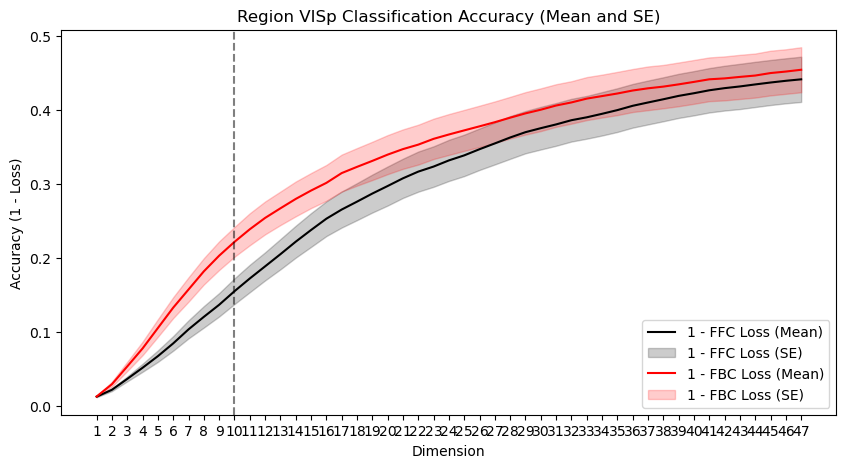

Max fold difference: 1.4298087333092746, at 10 dimensions


In [21]:
import numpy as np
import matplotlib.pyplot as plt

region = 'VISp'
dr_method_1 = 'PCA'
dr_method_2 = 'LQGCA'

# Extract losses per session for the region and methods
FFC_per_session = np.array([all_losses[dr_method_1][region]["per_session"][sess] for sess in sessions])
FBC_per_session = np.array([all_losses[dr_method_2][region]["per_session"][sess] for sess in sessions])

# Convert to (1 - loss)
FFC_per_session = 1 - FFC_per_session
FBC_per_session = 1 - FBC_per_session

# Calculate mean and SE over sessions
FFC_mean = FFC_per_session.mean(axis=0)
FFC_se = FFC_per_session.std(axis=0) / np.sqrt(FFC_per_session.shape[0])  # Standard error
FBC_mean = FBC_per_session.mean(axis=0)
FBC_se = FBC_per_session.std(axis=0) / np.sqrt(FBC_per_session.shape[0])  # Standard error

# Find the dimension with the maximum difference
Diff_mean = FBC_mean - FFC_mean
max_dim_ind = np.argmax(Diff_mean)
max_diff_dim = dimensions[max_dim_ind]

# Plot FFC with shaded SE
plt.figure(figsize=(10, 5))
plt.plot(dimensions, FFC_mean, label="1 - FFC Loss (Mean)", color='black')
plt.fill_between(dimensions, FFC_mean - FFC_se, FFC_mean + FFC_se, color='black', alpha=0.2, label="1 - FFC Loss (SE)")

# Plot FBC with shaded SE
plt.plot(dimensions, FBC_mean, label="1 - FBC Loss (Mean)", color='red')
plt.fill_between(dimensions, FBC_mean - FBC_se, FBC_mean + FBC_se, color='red', alpha=0.2, label="1 - FBC Loss (SE)")

# Add plot details
plt.legend()
plt.title(f'Region {region} Classification Accuracy (Mean and SE)')
plt.xticks(dimensions)
plt.xlabel('Dimension')
plt.ylabel('Accuracy (1 - Loss)')
plt.axvline(x=dimensions[max_dim_ind], color=[0, 0, 0, 0.5], linestyle='--') 
plt.show()

# Print fold difference at the dimension with the maximum difference
print(f"Max fold difference: {FBC_mean[max_dim_ind] / FFC_mean[max_dim_ind]}, at {dimensions[max_dim_ind]} dimensions")

In [1]:
import numpy as np
import matplotlib.pyplot as plt

region = 'VISp'
dr_method_1 = 'PCA'
dr_method_2 = 'LQGCA'


""""  




# Iterate over sessions and plot individual accuracy curves
for sess in sessions:
    # Extract losses per session and convert to accuracy (1 - loss)
    FFC_acc = 1 - np.array(all_losses[dr_method_1][region]["per_session"][sess])
    FBC_acc = 1 - np.array(all_losses[dr_method_2][region]["per_session"][sess])

    # Create figure
    plt.figure(figsize=(10, 5))
    
    # Plot FFC and FBC accuracy for this session
    plt.plot(dimensions, FFC_acc, label=f"FFC (Session {sess})", color='black')
    plt.plot(dimensions, FBC_acc, label=f"FBC (Session {sess})", color='red')

    # Add labels and titles
    plt.legend()
    plt.title(f'Region {region} - Session {sess} Classification Accuracy')
    plt.xticks(dimensions[::5])
    plt.xlabel('Dimension')
    plt.ylabel('Accuracy (1 - Loss)')
    plt.axvline(x=21, color=[0, 0, 0, 0.5], linestyle='--') 

    # Show plot
    plt.show()
    
    
"""

'"  \n\n\n\n\n# Iterate over sessions and plot individual accuracy curves\nfor sess in sessions:\n    # Extract losses per session and convert to accuracy (1 - loss)\n    FFC_acc = 1 - np.array(all_losses[dr_method_1][region]["per_session"][sess])\n    FBC_acc = 1 - np.array(all_losses[dr_method_2][region]["per_session"][sess])\n\n    # Create figure\n    plt.figure(figsize=(10, 5))\n    \n    # Plot FFC and FBC accuracy for this session\n    plt.plot(dimensions, FFC_acc, label=f"FFC (Session {sess})", color=\'black\')\n    plt.plot(dimensions, FBC_acc, label=f"FBC (Session {sess})", color=\'red\')\n\n    # Add labels and titles\n    plt.legend()\n    plt.title(f\'Region {region} - Session {sess} Classification Accuracy\')\n    plt.xticks(dimensions[::5])\n    plt.xlabel(\'Dimension\')\n    plt.ylabel(\'Accuracy (1 - Loss)\')\n    plt.axvline(x=21, color=[0, 0, 0, 0.5], linestyle=\'--\') \n\n    # Show plot\n    plt.show()\n    \n    \n'

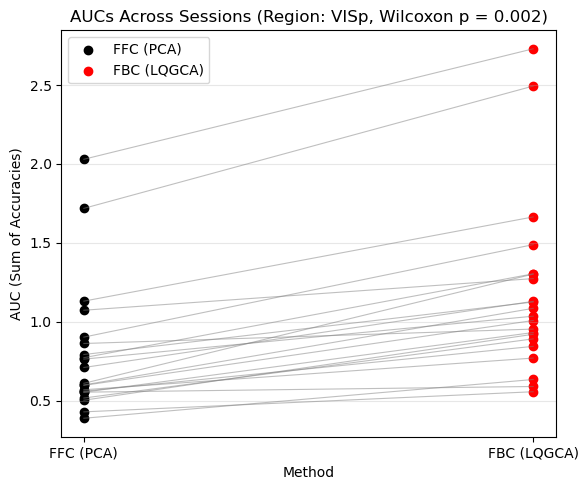

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ranksums

# Example: FFC_AUCs and FBC_AUCs are computed as before
# FFC_AUCs = [calculated values]
# FBC_AUCs = [calculated values]

# Perform Wilcoxon Rank Sum Test
statistic, p_value = ranksums(FBC_AUCs, FFC_AUCs)

# Define x positions for the two groups
x_FFC = 1  # All FFC points will be at x=1
x_FBC = 2  # All FBC points will be at x=2

# Create the plot
plt.figure(figsize=(6, 5))

# Plot and connect paired points
for ffc, fbc in zip(FFC_AUCs, FBC_AUCs):
    plt.plot([x_FFC, x_FBC], [ffc, fbc], color='gray', alpha=0.5, linestyle='-', linewidth=0.8)  # Thin line
    plt.scatter(x_FFC, ffc, color='black', label='FFC (PCA)' if ffc == FFC_AUCs[0] else "")  # FFC point
    plt.scatter(x_FBC, fbc, color='red', label='FBC (LQGCA)' if fbc == FBC_AUCs[0] else "")  # FBC point

# Customize x-axis
plt.xticks([x_FFC, x_FBC], ['FFC (PCA)', 'FBC (LQGCA)'])
plt.title(f'AUCs Across Sessions (Region: {region}, Wilcoxon p = {p_value:.1g})')
plt.ylabel('AUC (Sum of Accuracies)')
plt.xlabel('Method')
plt.grid(axis='y', alpha=0.3)

# Add legend
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

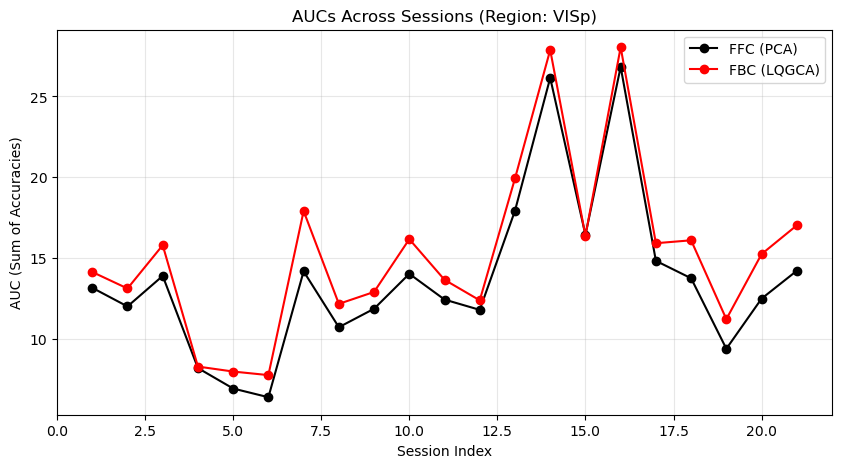

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Example: FFC_AUCs and FBC_AUCs are computed as before
# FFC_AUCs = [calculated values]
# FBC_AUCs = [calculated values]

# Define session indices for the x-axis
session_indices = range(1, len(sessions) + 1)

# Plot the AUCs for FFC and FBC
plt.figure(figsize=(10, 5))
plt.plot(session_indices, FFC_AUCs, label="FFC (PCA)", marker='o', color='black')
plt.plot(session_indices, FBC_AUCs, label="FBC (LQGCA)", marker='o', color='red')

# Add labels, legend, and title
plt.title(f'AUCs Across Sessions (Region: {region})')
plt.xlabel('Session Index')
plt.ylabel('AUC (Sum of Accuracies)')
plt.legend()
plt.grid(alpha=0.3)

# Show the plot
plt.show()

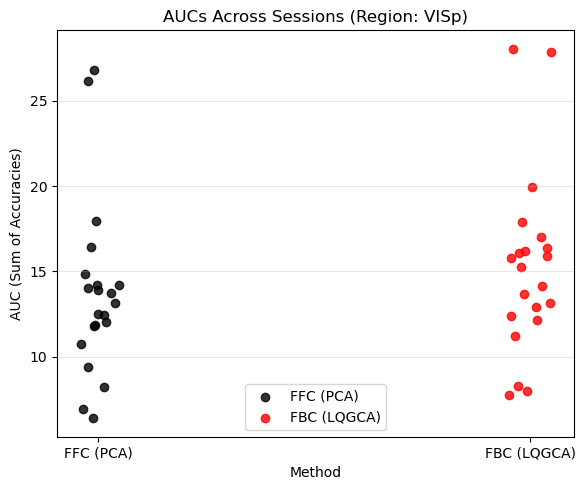

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Example: FFC_AUCs and FBC_AUCs are computed as before
# FFC_AUCs = [calculated values]
# FBC_AUCs = [calculated values]

# Add some jitter for better visualization
jitter = 0.05  # Small offset to spread points vertically

# Generate x positions for the two groups
x_FFC = np.ones(len(FFC_AUCs))  # All FFC points will be at x=1
x_FBC = np.ones(len(FBC_AUCs)) * 2  # All FBC points will be at x=2

# Add scatter points
plt.figure(figsize=(6, 5))
plt.scatter(x_FFC + np.random.uniform(-jitter, jitter, len(FFC_AUCs)), FFC_AUCs, label="FFC (PCA)", color='black', alpha=0.8)
plt.scatter(x_FBC + np.random.uniform(-jitter, jitter, len(FBC_AUCs)), FBC_AUCs, label="FBC (LQGCA)", color='red', alpha=0.8)

# Customize x-axis
plt.xticks([1, 2], ['FFC (PCA)', 'FBC (LQGCA)'])
plt.title(f'AUCs Across Sessions (Region: {region})')
plt.ylabel('AUC (Sum of Accuracies)')
plt.xlabel('Method')
plt.grid(axis='y', alpha=0.3)

# Add legend
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()